## Exploring Streamflow data

This notebook allows the user to obtain different statistics from the daily streamflow data located in the data folder. The input csv should have the following structure

| Fecha         | Q      |
| :------       | :--    |
| dd/MM/YYYY    | 30.2   |

#### Import libraries

In [15]:
# Importing the libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import os

from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

##### Define user variables

In [16]:
# csv filename
station_name = '1190'
# Percentage of missing data
max_pct_missing = 50
# Basin area
area_km2 = 690.20

In [17]:
# CSV folder
CSV_FOLDER = '..\..\..\Status_Outlook_Bulletin\stations\data'
CSV_FILE = os.path.join(CSV_FOLDER,station_name + '.csv')
print(CSV_FILE)

..\..\..\Status_Outlook_Bulletin\stations\data\1190.csv


In [18]:
# Read file
DISCHARGE_DAILY = pd.read_csv(CSV_FILE,parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")
# Identify the missing data
DISCHARGE_DAILY_date_missing = pd.date_range(start = DISCHARGE_DAILY.index[0].strftime('%Y-%m-%d'), end = DISCHARGE_DAILY.index[-1].strftime('%Y-%m-%d'),freq='D')
DISCHARGE_DAILY = DISCHARGE_DAILY.reindex(DISCHARGE_DAILY_date_missing,fill_value=None)
DISCHARGE_DAILY.index.name = 'Fecha' # Set index Fecha
DISCHARGE_DAILY.columns = ['Discharge']
## create column for day, month, year in the daily discharge ()
DISCHARGE_DAILY['year'] = DISCHARGE_DAILY.index.year
DISCHARGE_DAILY['month'] = DISCHARGE_DAILY.index.month
DISCHARGE_DAILY['monthday'] = DISCHARGE_DAILY.index.day_of_year
HTML(DISCHARGE_DAILY.tail(6).to_html())

,Discharge,year,month,monthday
Fecha,,,,
2025-04-25,0.123,2025,4,115
2025-04-26,0.227,2025,4,116
2025-04-27,0.145,2025,4,117
2025-04-28,0.123,2025,4,118
2025-04-29,0.123,2025,4,119
2025-04-30,0.123,2025,4,120


##### Plot hydrograph

In [19]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=DISCHARGE_DAILY.index,    
    y=DISCHARGE_DAILY['Discharge'], 
    mode='lines+markers',               
    name='Streamflow (m3/s)'
))

fig.update_layout(
    title=f'Hydrograph',
    xaxis_title='Date',
    yaxis_title='Discharge (m³/s)'
)

fig.show()

##### Duration Curve

In [20]:
DATA_DAILY = DISCHARGE_DAILY.dropna(subset=['Discharge'])
sorted_stage= DATA_DAILY['Discharge'].sort_values(ascending=False)
freq_stage = np.arange(1., len(sorted_stage) + 1) / len(sorted_stage)

df_freq = sorted_stage.to_frame(name='stage')
df_freq['frequency'] = freq_stage

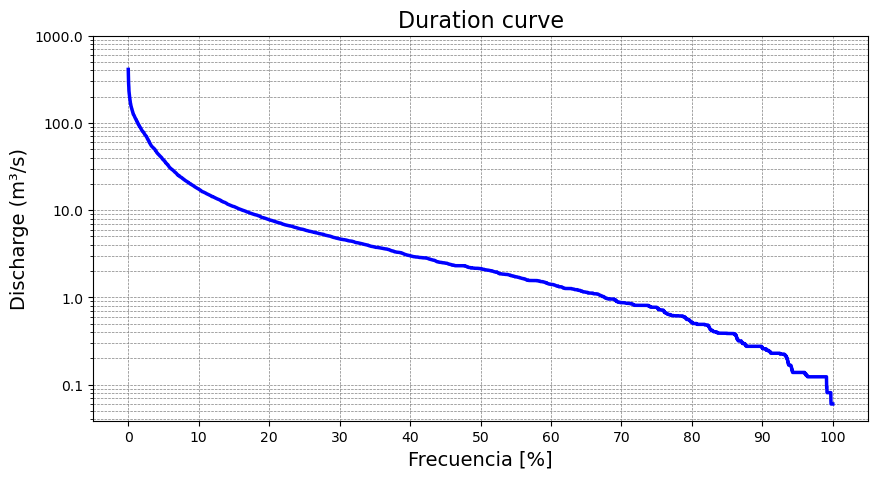

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# Create the matplotlib plot with adjusted figure size
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(freq_stage * 100, sorted_stage, color='blue', linewidth=2.5)

ax.set_title('Duration curve', fontsize=16)
ax.set_xlabel('Frecuencia [%]', fontsize=14)
ax.set_ylabel('Discharge (m³/s)', fontsize=14)

# Set y-axis to log scale
ax.set_yscale('log')

# Set x and y-axis ticks and format
ax.set_xticks(np.arange(0, 101, 10))
ax.set_yticks([0.1, 1, 10, 100, 1000])
ax.get_yaxis().set_major_formatter(ScalarFormatter())

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')


##### Convert to monthly

In [22]:
# from daily to monthly
DISCHARGE_MONTHLY = DISCHARGE_DAILY.resample('M',closed="right").apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < max_pct_missing else np.nan)
# from monthly to 3 months
DISCHARGE_THREE_MONTHS = DISCHARGE_MONTHLY.rolling(3).apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < max_pct_missing else np.nan)
# Create columns
DISCHARGE_MONTHLY['year'] = DISCHARGE_MONTHLY.index.year
DISCHARGE_MONTHLY['month'] = DISCHARGE_MONTHLY.index.month
DISCHARGE_MONTHLY['water_year'] = DISCHARGE_MONTHLY.index.year.where(DISCHARGE_MONTHLY.index.month >= 4, DISCHARGE_MONTHLY.index.year - 1)
## create column for day, month, year in the daily discharge ()
DISCHARGE_DAILY['year'] = DISCHARGE_DAILY.index.year
DISCHARGE_DAILY['month'] = DISCHARGE_DAILY.index.month
DISCHARGE_DAILY['day'] = DISCHARGE_DAILY.index.day
DISCHARGE_DAILY['monthday'] = DISCHARGE_DAILY.index.day_of_year
# The water year for this region starts in April (4)
DISCHARGE_DAILY['water_year'] = DISCHARGE_DAILY.index.year.where(DISCHARGE_DAILY.index.month >= 4, DISCHARGE_DAILY.index.year - 1)
# Change the day in the datetime column
DISCHARGE_MONTHLY.index = DISCHARGE_MONTHLY.index.map(lambda t: t.replace(day=1))
## print the first results
HTML(DISCHARGE_MONTHLY.tail(6).to_html(index=True))
# DISCHARGE_MONTHLY.to_clipboard() # Uncomment if you want to visualize all the time serie

,Discharge,year,month,monthday,water_year
Fecha,,,,,
2024-11-01,0.273767,2024,11,320.5,2024
2024-12-01,0.977323,2024,12,351.0,2024
2025-01-01,0.126419,2025,1,16.0,2024
2025-02-01,NaN,2025,2,45.5,2024
2025-03-01,NaN,2025,3,75.0,2024
2025-04-01,0.165967,2025,4,105.5,2025


#### Convert to daily volumen in m3 and hm3

In [23]:
# Convert daily discharge (m³/s) to daily volume (hm³)
seconds_in_a_day = 86400
DISCHARGE_DAILY['Daily_Volume_m3'] = DISCHARGE_DAILY['Discharge'] * seconds_in_a_day
DISCHARGE_DAILY['Daily_Volume_hm3'] = DISCHARGE_DAILY['Daily_Volume_m3'] / 1e6
HTML(DISCHARGE_DAILY.tail(6).to_html(index=True))

,Discharge,year,month,monthday,day,water_year,Daily_Volume_m3,Daily_Volume_hm3
Fecha,,,,,,,,
2025-04-25,0.123,2025,4,115,25,2025,10627.2,0.010627
2025-04-26,0.227,2025,4,116,26,2025,19612.8,0.019613
2025-04-27,0.145,2025,4,117,27,2025,12528.0,0.012528
2025-04-28,0.123,2025,4,118,28,2025,10627.2,0.010627
2025-04-29,0.123,2025,4,119,29,2025,10627.2,0.010627
2025-04-30,0.123,2025,4,120,30,2025,10627.2,0.010627


In [24]:
# Calculate the day of the water year (1 to 365/366)
def get_water_year_day(date):
    start_of_water_year = pd.Timestamp(year=date.year, month=4, day=1)
    if date.month < 4:
        start_of_water_year = pd.Timestamp(year=date.year - 1, month=4, day=1)
    
    return (date - start_of_water_year).days + 1

DISCHARGE_DAILY['day_of_water_year'] = DISCHARGE_DAILY.index.map(get_water_year_day)
HTML(DISCHARGE_DAILY.tail(6).to_html(index=True))

,Discharge,year,month,monthday,day,water_year,Daily_Volume_m3,Daily_Volume_hm3,day_of_water_year
Fecha,,,,,,,,,
2025-04-25,0.123,2025,4,115,25,2025,10627.2,0.010627,25
2025-04-26,0.227,2025,4,116,26,2025,19612.8,0.019613,26
2025-04-27,0.145,2025,4,117,27,2025,12528.0,0.012528,27
2025-04-28,0.123,2025,4,118,28,2025,10627.2,0.010627,28
2025-04-29,0.123,2025,4,119,29,2025,10627.2,0.010627,29
2025-04-30,0.123,2025,4,120,30,2025,10627.2,0.010627,30


##### How much it would take to fill the reservoir?

In [25]:
# Group by water_year and calculate the cumulative volume
df_cumulative = DISCHARGE_DAILY.groupby('water_year')['Daily_Volume_hm3'].cumsum().reset_index()
df_cumulative['day_of_water_year'] = DISCHARGE_DAILY['day_of_water_year'].values
df_cumulative['water_year'] = DISCHARGE_DAILY['water_year'].values
df_cumulative['Discharge'] = DISCHARGE_DAILY['Discharge'].values
# Filter the DataFrame for the last 10 water years (2014 to 2024)
df_filtered = df_cumulative[(df_cumulative['water_year'] >= 2000) & (df_cumulative['water_year'] <= 2020)]
HTML(df_filtered.tail(6).to_html(index=False))

Fecha,Daily_Volume_hm3,day_of_water_year,water_year,Discharge
2021-03-26,178.052774,360,2020,146.224
2021-03-27,182.783261,361,2020,54.751
2021-03-28,184.434624,362,2020,19.113
2021-03-29,185.635066,363,2020,13.894
2021-03-30,186.592810,364,2020,11.085
2021-03-31,187.432877,365,2020,9.723


In [26]:
# Create the plot
fig = px.line(
    df_filtered, 
    x='day_of_water_year', 
    y='Daily_Volume_hm3', 
    color='water_year',
    title='Cumulative Volume by Water Year',
    labels={'day_of_water_year': 'Day of Water Year', 'Daily_Volume_hm3': 'Cumulative Volume (hm³)'}
)

# Add a horizontal line at 118 hm3 - Casupá Reservoir Capacity
fig.add_hline(y=118, line_dash="dash", line_color="red", annotation_text="118 hm³", annotation_position="top left")

# Customize the plot layout
fig.update_layout(
    xaxis_title='Day of Water Year',
    yaxis_title='Volume (hm³)'
)

# Show the plot
fig.show()

##### Climatology 

In [34]:
DISCHARGE_SELECTION = DISCHARGE_MONTHLY[(DISCHARGE_MONTHLY['year'] >= 1980) & (DISCHARGE_MONTHLY['year'] <= 2010)]
DISCHARGE_AVERAGE = DISCHARGE_SELECTION.groupby(DISCHARGE_SELECTION.month).mean()
DISCHARGE_AVERAGE = DISCHARGE_AVERAGE.reindex(columns=['Discharge'])
HTML(DISCHARGE_AVERAGE.transpose().round(decimals=2).to_html())

month,1,2,3,4,5,6,7,8,9,10,11,12
Discharge,2.21,5.71,5.11,6.17,10.36,12.91,14.24,12.78,12.83,10.45,7.79,3.12


In [28]:
import plotly.express as px

# Agregar columna con abreviaturas de mes en español
meses = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN',
         'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']

DISCHARGE_AVERAGE = DISCHARGE_AVERAGE.copy()
DISCHARGE_AVERAGE['Mes'] = [meses[m-1] for m in DISCHARGE_AVERAGE.index]

# Crear gráfico de barras
fig = px.bar(DISCHARGE_AVERAGE,
             x='Mes',
             y='Discharge',
             labels={'Discharge': 'Discharge (m³/s)', 'Mes': 'Month'},
             title='Monthly Discharge')

fig.update_layout(
    xaxis_tickfont=dict(size=14),
    yaxis_tickfont=dict(size=14),
    title_font=dict(size=20)
)

fig.show()

##### Calculate annual statistics

In [29]:
q = (DISCHARGE_SELECTION['Discharge'].mean() * 1000) / area_km2
v = (DISCHARGE_SELECTION['Discharge'].mean() * 31557600) / 1000000 # Convert from m3/s to hm3/year

print(f"El caudal promedio anual es (1980-2010): {DISCHARGE_SELECTION['Discharge'].mean():.1f} m³/s")
print(f"El caudal especifico es (1980-2010): {q:.1f} l/s/km²")
print(f"El volumen anual promedio es (1980-2010):{v:.1f} hm³")
print(f"El q80 anual (Caudal frecuencia 80% del tiempo) es (1980-2010): {np.percentile(DATA_DAILY['Discharge'], 20):.1f} m³/s")

El caudal promedio anual es (1980-2010): 8.7 m³/s
El caudal especifico es (1980-2010): 12.5 l/s/km²
El volumen anual promedio es (1980-2010):273.1 hm³
El q80 anual (Caudal frecuencia 80% del tiempo) es (1980-2010): 0.5 m³/s


##### Monthly period

In [30]:
# Define the monthly periods
monthly_periods = {
    1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dic'
}

results = {}

for month_num, month_label in monthly_periods.items():
    # Filter the monthly data for the current month
    monthly_data = DISCHARGE_SELECTION[DISCHARGE_SELECTION['month'] == month_num]
    
    # Calculate the mean discharge
    mean_discharge = monthly_data['Discharge'].mean()
    
    # Calculate q and Q80
    q = (mean_discharge * 1000) / area_km2
    Q80 = np.nanpercentile(monthly_data['Discharge'], 20)
    Q20 = np.nanpercentile(monthly_data['Discharge'], 80)
    Q90 = np.nanpercentile(monthly_data['Discharge'], 10)
    Q10 = np.nanpercentile(monthly_data['Discharge'], 90)
    Q60 = np.nanpercentile(monthly_data['Discharge'], 40)
    Q40 = np.nanpercentile(monthly_data['Discharge'], 60)

    Qmax = np.nanmax(monthly_data['Discharge'])
    Qmin = np.nanmin(monthly_data['Discharge'])

    # Specific discharge
    q80 = (Q80*1000)/area_km2
    q20 = (Q20*1000)/area_km2
    qmax = (Qmax*1000)/area_km2
    qmin = (Qmin*1000)/area_km2
    
    # Calculate the average monthly volume
    seconds_in_a_year = 31557600
    seconds_in_a_month_avg = seconds_in_a_year / 12
    v_month = (mean_discharge * seconds_in_a_month_avg) / 1e6

    results[month_label] = {'mean_discharge (m³/s)': mean_discharge, 
                            'q (l/s/km²)': q, 
                            'Vol (hm³)': v_month, 
                            'Q80 (m³/s)': Q80, 
                            'q80 (l/s/km²)':q80,
                            'Q20 (m³/s)':Q20,
                            'q20 (l/s/km²)':q20,
                            'qmax (l/s/km²)':qmax,
                            'qmin (l/s/km²)':qmin}

# Print the results in a clear format
for month, values in results.items():
    print(f"--- Resultados para {month} ---")
    print(f"El caudal promedio (1980-2010): {values['mean_discharge (m³/s)']:.2f} m³/s")
    print(f"El caudal especifico (1980-2010): {values['q (l/s/km²)']:.2f} l/s/km²")
    print(f"El volumen mensual promedio (1980-2010): {values['Vol (hm³)']:.2f} hm³")
    print(f"El 180 (Caudal frecuencia 80% del tiempo) es (1980-2010): {values['Q80 (m³/s)']:.2f} m³/s ({(values['Q80 (m³/s)']*1000)/area_km2:.1f} l/s/km²)")
    print()

--- Resultados para Ene ---
El caudal promedio (1980-2010): 2.21 m³/s
El caudal especifico (1980-2010): 3.19 l/s/km²
El volumen mensual promedio (1980-2010): 5.80 hm³
El 180 (Caudal frecuencia 80% del tiempo) es (1980-2010): 0.40 m³/s (0.6 l/s/km²)

--- Resultados para Feb ---
El caudal promedio (1980-2010): 5.71 m³/s
El caudal especifico (1980-2010): 8.27 l/s/km²
El volumen mensual promedio (1980-2010): 15.02 hm³
El 180 (Caudal frecuencia 80% del tiempo) es (1980-2010): 0.48 m³/s (0.7 l/s/km²)

--- Resultados para Mar ---
El caudal promedio (1980-2010): 5.11 m³/s
El caudal especifico (1980-2010): 7.40 l/s/km²
El volumen mensual promedio (1980-2010): 13.43 hm³
El 180 (Caudal frecuencia 80% del tiempo) es (1980-2010): 0.41 m³/s (0.6 l/s/km²)

--- Resultados para Abr ---
El caudal promedio (1980-2010): 6.17 m³/s
El caudal especifico (1980-2010): 8.93 l/s/km²
El volumen mensual promedio (1980-2010): 16.22 hm³
El 180 (Caudal frecuencia 80% del tiempo) es (1980-2010): 1.02 m³/s (1.5 l/s/km²

In [31]:
# Create the DataFrame from the results dictionary
df_results = pd.DataFrame(results).round(decimals=1)
# Define the new desired order of months
new_order = ['Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic', 'Ene', 'Feb', 'Mar']
# Reorder the DataFrame columns
df_results = df_results[new_order]
df_results

,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Ene,Feb,Mar
mean_discharge (m³/s),6.2,10.4,12.9,14.2,12.8,12.8,10.5,7.8,3.1,2.2,5.7,5.1
q (l/s/km²),8.9,15.0,18.7,20.6,18.5,18.6,15.1,11.3,4.5,3.2,8.3,7.4
Vol (hm³),16.2,27.2,34.0,37.5,33.6,33.7,27.5,20.5,8.2,5.8,15.0,13.4
Q80 (m³/s),1.0,1.4,2.8,6.9,4.0,5.4,2.0,1.5,0.5,0.4,0.5,0.4
q80 (l/s/km²),1.5,2.0,4.0,10.0,5.7,7.8,2.8,2.1,0.8,0.6,0.7,0.6
Q20 (m³/s),6.9,15.7,21.0,21.9,17.1,17.8,15.8,14.1,3.8,3.1,7.5,7.2
q20 (l/s/km²),10.0,22.8,30.4,31.8,24.8,25.8,22.9,20.5,5.5,4.5,10.8,10.4
qmax (l/s/km²),52.8,61.9,56.7,51.3,89.1,59.2,40.0,45.4,31.7,19.0,64.2,64.8
qmin (l/s/km²),0.3,0.8,0.6,0.7,1.1,2.9,0.8,0.3,0.2,0.1,0.1,0.2


#### Four-month period analysis

In [32]:
# Define the periods
periods = {
    'q1': ([4, 5, 6, 7],"ABR-JUL"),
    'q2': ([8, 9, 10, 11],"AGO-NOV"),
    'q3': ([12, 1, 2, 3],"DIC-MAR")
}

results = {}

for period_name, (months, period_label) in periods.items():
    # Filter the monthly data for the current period
    DISCHARGE_q = DISCHARGE_SELECTION[DISCHARGE_SELECTION.index.month.isin(months)]

    # Calculate the mean discharge
    mean_discharge = DISCHARGE_q['Discharge'].mean()

    # Calculate q and q80
    q = (mean_discharge * 1000) / area_km2
    q80 = np.nanpercentile(DISCHARGE_q['Discharge'], 20)
    q60 = np.nanpercentile(DISCHARGE_q['Discharge'], 40)
    q90 = np.nanpercentile(DISCHARGE_q['Discharge'], 10)

    # Calculate the average four-month volume
    seconds_in_a_year = 31557600
    seconds_in_four_months = seconds_in_a_year * (4/12)
    v_four_month = (mean_discharge * seconds_in_four_months) / 1e6

    results[period_name] = {'mean_discharge (m³/s)': mean_discharge, 
                            'q (l/s/km²)': q, 
                            'Vol (hm³)': v_four_month, 
                            'period_label': period_label, 
                            'q80 (l/s/km²)': q80}

# Print the results in the user's requested format
for period_name, values in results.items():
    print(f"--- Resultados para {values['period_label']} ---")
    print(f"El caudal promedio (1980-2010): {values['mean_discharge (m³/s)']:.1f} m³/s")
    print(f"El caudal especifico (1980-2010): {values['q (l/s/km²)']:.1f} l/s/km²")
    print(f"El volumen cuatrimestral promedio (1980-2010): {values['Vol (hm³)']:.1f} hm³")
    print(f"El q80 (Caudal frecuencia 80% del tiempo) es (1980-2010): {values['q80 (l/s/km²)']:.2f} m³/s")
    print()

--- Resultados para ABR-JUL ---
El caudal promedio (1980-2010): 11.0 m³/s
El caudal especifico (1980-2010): 15.9 l/s/km²
El volumen cuatrimestral promedio (1980-2010): 115.3 hm³
El q80 (Caudal frecuencia 80% del tiempo) es (1980-2010): 1.43 m³/s

--- Resultados para AGO-NOV ---
El caudal promedio (1980-2010): 10.9 m³/s
El caudal especifico (1980-2010): 15.9 l/s/km²
El volumen cuatrimestral promedio (1980-2010): 115.2 hm³
El q80 (Caudal frecuencia 80% del tiempo) es (1980-2010): 3.12 m³/s

--- Resultados para DIC-MAR ---
El caudal promedio (1980-2010): 4.1 m³/s
El caudal especifico (1980-2010): 5.9 l/s/km²
El volumen cuatrimestral promedio (1980-2010): 42.6 hm³
El q80 (Caudal frecuencia 80% del tiempo) es (1980-2010): 0.44 m³/s



In [33]:
# Assuming 'results' is your dictionary variable
for period_name in results:
    results[period_name].pop('period_label', None)

# Create the DataFrame from the results dictionary
df_results_fourmonth = pd.DataFrame(results)

# Now apply rounding to the numerical values
df_results_fourmonth = df_results_fourmonth.round(decimals=1)

# Rename the columns for better readability
df_results_fourmonth.rename(columns={'q1': 'ABR-JUL', 'q2': 'AGO-NOV', 'q3': 'DIC-MAR'}, inplace=True)

# Display the final, corrected DataFrame
df_results_fourmonth

,ABR-JUL,AGO-NOV,DIC-MAR
mean_discharge (m³/s),11.0,10.9,4.1
q (l/s/km²),15.9,15.9,5.9
Vol (hm³),115.3,115.2,42.6
q80 (l/s/km²),1.4,3.1,0.4
